In [1]:
from PIL import Image
import requests
import torch
from torchvision import io
from typing import Dict
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor

In [2]:
# Load the model in half-precision on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
# TODO: go through _preprocess in Qwen2VLImageProcessor

# TODO: how does resize, normalize, rescale change image?
processor

Qwen2VLProcessor:
- image_processor: Qwen2VLImageProcessor {
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "Qwen2VLImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "max_pixels": 12845056,
  "merge_size": 2,
  "min_pixels": 3136,
  "patch_size": 14,
  "processor_class": "Qwen2VLProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "max_pixels": 12845056,
    "min_pixels": 3136
  },
  "temporal_patch_size": 2
}

- tokenizer: Qwen2TokenizerFast(name_or_path='Qwen/Qwen2-VL-7B-Instruct', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'eos_token': '<|im_end|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>', '<|object_ref_start|>', '<|object_ref_end|>', '<|box_start|>', 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7192703..2.145897].


(1365, 2048, 3)
(1372, 2044, 3)


NameError: name 'quit' is not defined

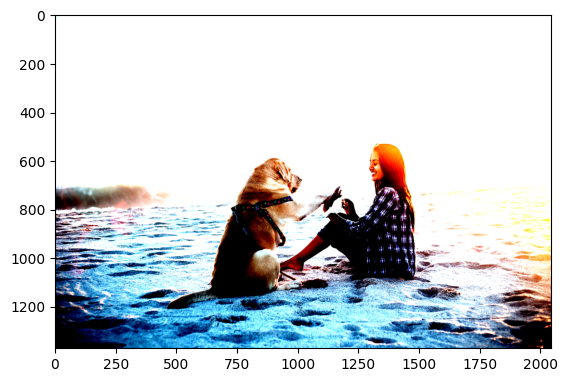

In [3]:
# Image
url = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
image = Image.open(requests.get(url, stream=True).raw)

conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]


# Preprocess the inputs
text_prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# Excepted output: '<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Describe this image.<|im_end|>\n<|im_start|>assistant\n'

inputs = processor(
    text=[text_prompt], images=[image], padding=True, return_tensors="pt"
)
inputs = inputs.to(model.device)

In [8]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])

In [5]:
# Inference: Generation of the output
output_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
print(output_text)

["The image depicts a serene beach scene with a woman and her dog enjoying a moment together. The woman is sitting on the sandy beach, facing the ocean, and appears to be engaging in a playful activity with her dog. The dog, which is a large breed, is sitting on its hind legs and extending its front paw towards the woman's hand. The woman is smiling and seems to be enjoying the interaction, as she is holding out her hand for the dog to touch. \n\nThe woman is dressed in casual attire, wearing a plaid shirt and dark pants. She has long hair that is flowing freely in the breeze. The dog is"]
